In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import quandl
import datetime
import os


SEED = 42

import tensorflow as tf
from tensorflow.keras.callbacks import Callback

### Getting the Amazon data

In [232]:
start = datetime.datetime(2012,1,1)
end = datetime.date.today()
quandl.ApiConfig.api_key = "1sW4FWcqKdfzHmMzKnPr"
amz = quandl.get("WIKI/AMZN", start_date=start, end_date=end)
amz.shape

(1566, 12)

In [202]:
class PrintDots(Callback):
    """ Print dots to monitor the progress of the fit
    """
    def on_epoch_end(self, epoch, logs):
        logs = logs or {}
        value = logs.get('val_loss')
        if epoch % 50 == 0:
            print(' epochs = ', epoch, ' val_loss = ', value)
        print('*', end='')
                
class TerminateOnBaseline(Callback):
    """ Callback that terminates training when monitored value reaches a specified baseline
    """
    def __init__(self, monitor='val_loss', patience=50):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = np.Inf
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = np.Inf
        self.best_weights = None
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        value = logs.get(self.monitor)
        if epoch == 0:
            self.baseline = value/1000.
        if np.less(value, self.best):
            self.best = value
            self.wait = 0
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
        else:
            self.wait += 1
        if value is not None:
            if value <= self.baseline and self.wait >= self.patience:
                self.stopped_epoch = epoch
                print('\nepoch %d: Reached baseline, terminating training and lost patience' % epoch)
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch: ' + str(self.best_epoch))
                self.model.set_weights(self.best_weights)
            elif self.wait >= self.patience:
                self.baseline *= 2.5
                self.wait = self.patience/2
                

def plot_history(history):
    """ Plots to track the history of the metrics
        argument:
            history: the history object from the DNN fit
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.plot(hist['epoch'], hist['mse'], label='train mse')
    plt.plot(hist['epoch'], hist['val_mse'], label='val mse')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('mae [%]')
    plt.plot(hist['epoch'], hist['mae']*100., label='train mae')
    plt.plot(hist['epoch'], hist['val_mae']*100., label='val mae')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print('Forecasting Mean Absolute Error (from validation data): {:4.2f}%'.format(np.min(hist['mae'].values)*100))
    
def plot_prediction(test, prediction, dates, pos=0):
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(dates, test[pos:], label='Real Price', linewidth=2)
    plt.plot(dates, prediction, label='Predicted Price', linewidth=2)
    plt.title('Amazon Stocks')
    plt.xlabel('dates')
    plt.ylabel('Stock Price in $')
    plt.grid(':', alpha=0.7)
    plt.legend()
    
    plt.subplot(1,2,2)
    dev = ((prediction.T-test.T)/test.T*100)
    plt.plot(dates, [0]*dev.shape[1], linewidth=2)
    plt.plot(dates, dev[0], linewidth=2)
    plt.ylabel('deviation in %')
    plt.xlabel('dates')
    plt.grid(':', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print('Forecasting Mean Absolute Error (from test data): {:4.2f}%'.format(np.mean(np.abs(prediction-test)/test)*100))
    

def rollingwindow(df, past=30, future=0, year0='2016', year1='2017', scale=True):
    X_train = []
    Y_train = []
    X_test = []
    
    if scale:
    # scale the whole dataset
        index = df.index
        scaler = MinMaxScaler(feature_range=(0,1))
        df_scaled = pd.DataFrame(scaler.fit_transform(df))
        df_scaled.index = index
    else:
        scaler = None
        df_scaled = df
    
    # define training data
    training_data = df_scaled[:year0].values
    
    # rolling window form data
    for i in range(past, training_data.shape[0]-future):
        X_train.append(training_data[i-past:i, 0])
        if future == 0: Y_train.append(training_data[i, 0])
        else: Y_train.append(training_data[i:i+future, 0])
    
    # reshaping etc.
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    if future != 0: Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
        
    # test data
    Y_test = df_scaled[year1:]

    # input data for predictions
    inputs = df_scaled[df_scaled.shape[0] - Y_test.shape[0] - past:].values
    inputs = inputs.reshape(-1,1)
    
    for i in range(past, inputs.shape[0]-future):
        X_test.append(inputs[i-past:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, Y_train, X_test, Y_test, scaler

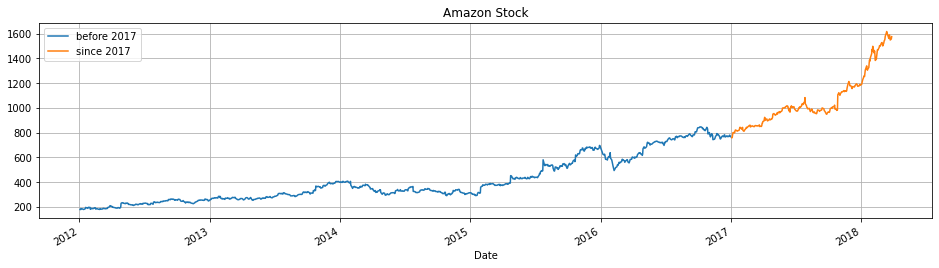

In [234]:
year0 = '2016'
year1 = '2017'
dataset = amz.iloc[:,:5]

data = dataset.iloc[:,1:2]

dataset['High'][:year0].plot(figsize=(16,4), legend=True)
dataset['High'][year1:].plot(figsize=(16,4), legend=True)
plt.legend(['before '+year1, 'since '+year1])
plt.title('Amazon Stock')
plt.grid(':')
plt.show()

_____________________
### The DNN solution for next day prediction

In [203]:
X_train, Y_train, X_test, Y_test, scaler = rollingwindow(data, past=30, future=0, year0='2016', year1='2017', scale=False)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])

now = datetime.datetime.now()
dense_nn = tf.keras.Sequential()
dense_nn.add(tf.keras.layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]))
dense_nn.add(tf.keras.layers.Dense(64, activation='relu'))
dense_nn.add(tf.keras.layers.Dense(64, activation='relu'))
dense_nn.add(tf.keras.layers.Dense(64, activation='relu'))
dense_nn.add(tf.keras.layers.Dense(1, activation='relu'))

dense_nn.compile(optimizer='adam',
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])

dense_nn.summary()
history = dense_nn.fit(X_train, Y_train,
                           epochs=2000, batch_size=32, validation_split=0.2, verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', patience=100), PrintDots()])

print('\nruntime: {}'.format(datetime.datetime.now() - now))

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_209 (Dense)            (None, 64)                1984      
_________________________________________________________________
dense_210 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_211 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_212 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 65        
Total params: 14,529
Trainable params: 14,529
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  831.6896362304688
************************************************** epochs =  50  val_lo

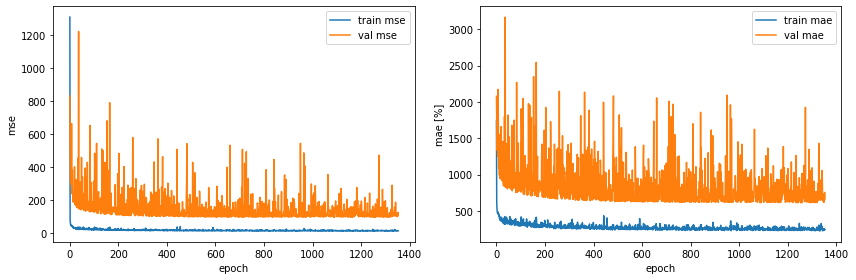

Forecasting Mean Absolute Error (from validation data): 223.81%


In [204]:
plot_history(history)

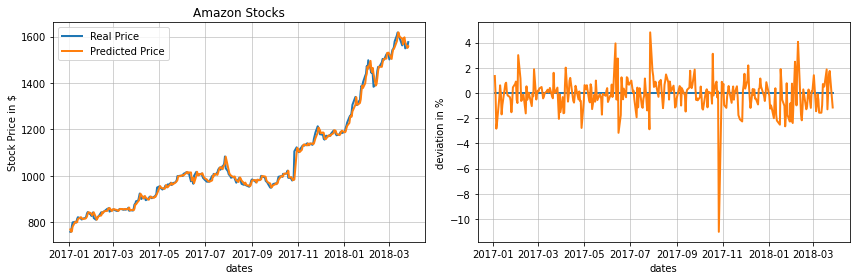

Forecasting Mean Absolute Error (from test data): 0.87%


In [206]:
# predicted_prices = scaler.inverse_transform(dense_nn.predict(X_test.reshape(X_test.shape[0],X_test.shape[1])))
# test_data = scaler.inverse_transform(Y_test.values)
predicted_prices = dense_nn.predict(X_test.reshape(X_test.shape[0],X_test.shape[1]))
test_data = Y_test.values
dates = Y_test.index
plot_prediction(test_data, predicted_prices, dates)

_____________________________
### The DNN solution for multi-days prediction

In [228]:
X_train, Y_train, X_test, Y_test, scaler = rollingwindow(data, past=30, future=7, year0='2016', year1='2017')
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

now = datetime.datetime.now()
dense_nn = tf.keras.Sequential()
dense_nn.add(tf.keras.layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]))
dense_nn.add(tf.keras.layers.Dense(64, activation='relu'))
dense_nn.add(tf.keras.layers.Dense(64, activation='relu'))
dense_nn.add(tf.keras.layers.Dense(64, activation='relu'))
dense_nn.add(tf.keras.layers.Dense(Y_train.shape[1], activation='relu'))

dense_nn.compile(optimizer='adam',
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])

dense_nn.summary()
history = dense_nn.fit(X_train, Y_train,
                           epochs=2000, batch_size=32, validation_split=0.2, verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', patience=100), PrintDots()])

print('\nruntime: {}'.format(datetime.datetime.now() - now))

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_272 (Dense)            (None, 64)                1984      
_________________________________________________________________
dense_273 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_274 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_275 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_276 (Dense)            (None, 7)                 455       
Total params: 14,919
Trainable params: 14,919
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.018641864880919456
************************************************** epochs =  50  val

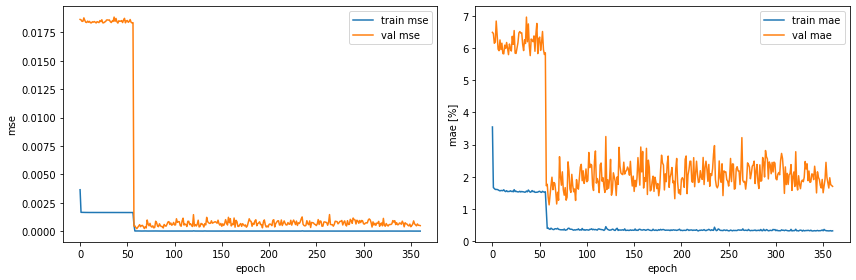

Forecasting Mean Absolute Error (from validation data): 0.31%


In [229]:
plot_history(history)

In [231]:
y_pred = dense_nn.predict(X_test)
scaler.inverse_transform(y_pred)[0]

array([774.7422 , 771.3999 , 751.2225 , 734.41724, 767.3786 , 769.1708 ,
       756.2402 ], dtype=float32)

In [217]:
Y_test.values[:7]

array([[758.7595],
       [759.68  ],
       [782.3999],
       [799.44  ],
       [801.7742],
       [798.    ],
       [799.5   ]])

____________________________________
### The Bi-GRU solution for single day prediction

In [235]:
X_train, Y_train, X_test, Y_test, scaler = rollingwindow(data, past=30, future=0, year0='2016', year1='2017')

now = datetime.datetime.now()
time_machine = tf.keras.Sequential()
time_machine.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=64, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
time_machine.add(tf.keras.layers.Dropout(0.2))
time_machine.add(tf.keras.layers.Dense(units=1))
time_machine.summary()

time_machine.compile(optimizer='rmsprop',
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])
history = time_machine.fit(X_train, Y_train,
                           epochs=500, batch_size=32, validation_split=0.2, verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', patience=30), PrintDots()])

print('\nruntime: {}'.format(datetime.datetime.now() - now))

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_14 (Bidirectio (None, 128)               25728     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_278 (Dense)            (None, 1)                 129       
Total params: 25,857
Trainable params: 25,857
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.0008659749873913825
************************************************** epochs =  50  val_loss =  0.00031182097154669464
************************************************** epochs =  100  val_loss =  0.0001369948877254501
************************************************** epochs =  150  val_loss =  8.065917063504457e-05
*******************************

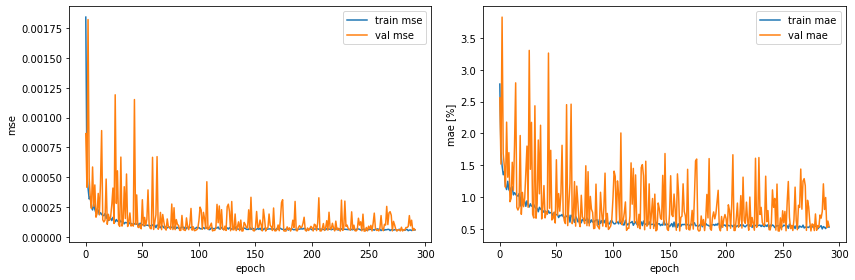

Forecasting Mean Absolute Error (from validation data): 0.50%


In [236]:
plot_history(history)

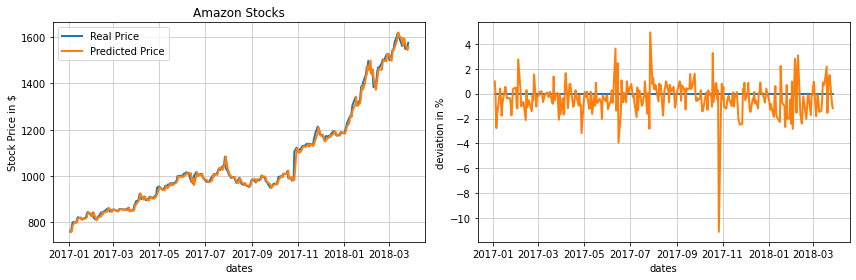

Forecasting Mean Absolute Error (from test data): 0.89%


In [237]:
predicted_prices = scaler.inverse_transform(time_machine.predict(X_test))
test_data = scaler.inverse_transform(Y_test.values)
dates = Y_test.index
plot_prediction(test_data, predicted_prices, dates)

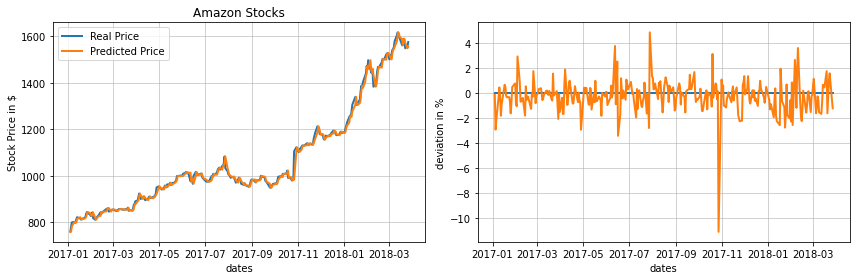

Forecasting Mean Absolute Error (from test data): 0.86%


In [14]:
plot_prediction(test_data[1:], test_data[:-1], dates[1:])

________________________________________
### The bi-GRU solution for multi-days prediction

In [10]:
X_train, Y_train, X_test, Y_test, scaler = rollingwindow(data, past=30, future=7, year0='2016', year1='2017')

now = datetime.datetime.now()
tardis = tf.keras.Sequential()
tardis.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=64, activation='tanh', return_sequences=False, stateful=False), input_shape=(X_train.shape[1], X_train.shape[2])))
# tardis.add(tf.keras.layers.Dropout(0.2))
tardis.add(tf.keras.layers.RepeatVector(Y_train.shape[1]))
tardis.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=64, activation='tanh', return_sequences=True, stateful=False)))
# tardis.add(tf.keras.layers.Dropout(0.2))
# tardis.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=96, activation='relu')))
tardis.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1)))
tardis.summary()

tardis.compile(optimizer='adam',
               loss='mean_squared_error',
               metrics=['mse', 'mae'])

history = tardis.fit(X_train, Y_train,
                           epochs=300, batch_size=32, validation_split=0.2, verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', patience=30), PrintDots()])

print('\nruntime: {}'.format(datetime.datetime.now() - now))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               25728     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 7, 128)            74496     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              129       
Total params: 100,353
Trainable params: 100,353
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.0018801596015691757
************************************************** epochs =  50  val_loss =  0.00027595044230110943
************************************************** epochs =  100  val_loss =  0.000473073741886764

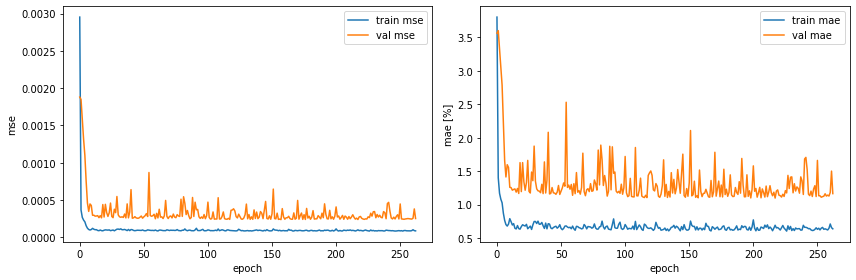

Forecasting Mean Absolute Error (from validation data): 0.60%


In [12]:
plot_history(history)

In [13]:
Y_pred = tardis.predict(X_test[250].reshape(1,30,1))

In [14]:
(scaler.inverse_transform(Y_pred.reshape(7,1))-scaler.inverse_transform(Y_test.iloc[249:256].values))/scaler.inverse_transform(Y_test.iloc[249:256].values)*100

array([[ 0.56686786],
       [-1.44644728],
       [-1.99377434],
       [-2.85759854],
       [-4.76487419],
       [-5.1665769 ],
       [-3.94328733]])

In [15]:
scaler.inverse_transform(Y_pred.reshape(1,-1))

array([[1196.7457, 1188.0532, 1191.6283, 1194.0161, 1193.3723, 1194.2657,
        1204.8682]], dtype=float32)

In [283]:
scaler.inverse_transform(Y_test.iloc[249:256].values)

array([[1190.  ],
       [1205.49],
       [1215.87],
       [1229.14],
       [1253.08],
       [1259.33],
       [1254.33]])

In [149]:
Y_train[0]

array([0.00923372, 0.00238312, 0.0035851 , 0.00451612, 0.00329329,
       0.00173697, 0.00173002])

In [154]:
Y_pred.reshape(7,).reshape(1, -1).shape

(1, 7)

In [160]:
tardis.predict(X_test[-1].reshape(1,30,1))

array([[[-0.02997916],
        [-0.0513855 ],
        [-0.06588215],
        [-0.07537824],
        [-0.08147144],
        [-0.08532511],
        [-0.08773333]]], dtype=float32)

In [164]:
Y_train.shape

(1221, 7)